In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

In [2]:
train_file = open("./Full-labels-2.txt")
lines = train_file.readlines()
train_file.close()

filenames = []
labels = []

for line in lines:
    filenames.append('Celeb-DF-Image-Face-Crop/'+line[2:].rstrip('\n'))    
for l in lines:
    labels.append(l[:1])

labels = [int(i) for i in labels]

train_filenames, val_filenames, train_labels, val_labels = train_test_split(
    filenames, labels, train_size=0.85, random_state=420)

num_train = len(train_filenames)
num_val = len(val_filenames)

In [3]:
train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels)))

val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels)))

In [4]:
#  function that can load the images from file and perform any necessary preprocessing.

IMAGE_SIZE = 128
BATCH_SIZE = 32

def _parse_fn(img, label):
    img_string = tf.io.read_file(img)
    img_decoded = tf.image.decode_jpeg(img_string)
    img_normalized = (tf.cast(img_decoded, tf.float32)/127.5) - 1
    img_resized = tf.image.resize(img_normalized, (IMAGE_SIZE, IMAGE_SIZE))
    #img_preprocess = tf.keras.applications.mobilenet_v2.preprocess_input(img_resized)
    return img_resized, label

train_data = (train_data.map(_parse_fn).shuffle(buffer_size=1000).batch(BATCH_SIZE))
val_data = (val_data.map(_parse_fn).shuffle(buffer_size=1000).batch(BATCH_SIZE))

In [5]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

In [6]:
base_model.trainable = False

In [7]:
#base_model.summary()

In [8]:
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

learning_rate = 0.0001

model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
epochs = 40
steps_per_epoch = 100
val_steps = 20


history = model.fit(train_data.repeat(),
                      epochs = epochs,
                      steps_per_epoch = steps_per_epoch,
                      validation_data = val_data.repeat(), 
                      validation_steps = val_steps)

Epoch 1/40
100/100 [==============================] - 22s 222ms/step - loss: 0.8665 - accuracy: 0.6803 - val_loss: 0.5029 - val_accuracy: 0.8484
Epoch 2/40
100/100 [==============================] - 19s 190ms/step - loss: 0.5082 - accuracy: 0.8273 - val_loss: 0.4656 - val_accuracy: 0.8422
Epoch 3/40
100/100 [==============================] - 18s 178ms/step - loss: 0.4724 - accuracy: 0.8469 - val_loss: 0.4715 - val_accuracy: 0.8562
Epoch 4/40
100/100 [==============================] - 19s 190ms/step - loss: 0.4507 - accuracy: 0.8450 - val_loss: 0.4318 - val_accuracy: 0.8422
Epoch 5/40
100/100 [==============================] - 19s 186ms/step - loss: 0.4638 - accuracy: 0.8362 - val_loss: 0.4139 - val_accuracy: 0.8625
Epoch 6/40
100/100 [==============================] - 18s 182ms/step - loss: 0.4258 - accuracy: 0.8566 - val_loss: 0.4530 - val_accuracy: 0.8516
Epoch 7/40
100/100 [==============================] - 19s 189ms/step - loss: 0.4170 - accuracy: 0.8522 - val_loss: 0.4545 - val_ac

In [11]:
model.save_weights('./ResNet-SRM-Weights/weights_epoch_30.h5')

In [12]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

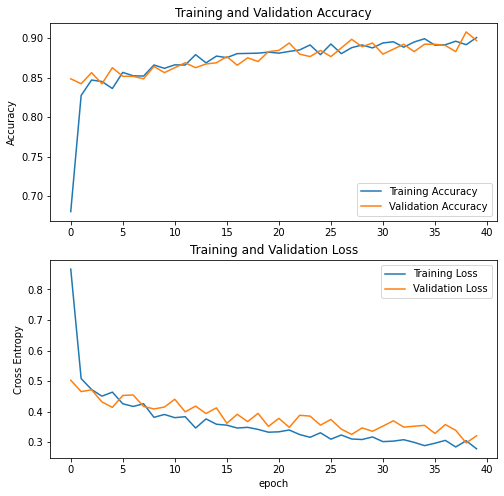

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
pred = model.predict(val_data, verbose=1)

28/28 [==============================] - 3s 117ms/step


In [15]:
model.evaluate(val_data)

28/28 [==============================] - 3s 119ms/step - loss: 0.3355 - accuracy: 0.8932


[0.3355223536491394, 0.8932262063026428]

In [16]:
from sklearn.metrics import roc_auc_score
y_true = np.array(val_labels)
y_scores = pred
roc_auc_score(y_true, y_scores)

0.5147408084037451

[[755   0]
 [116   0]]



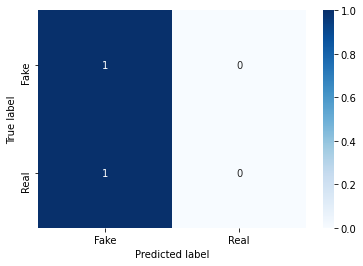

In [17]:
tf.math.confusion_matrix(y_true, y_scores)

classes=["Fake", "Real"]

con_mat = tf.math.confusion_matrix(labels=y_true.ravel(), predictions=y_scores.ravel(), num_classes=2).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
print(con_mat)
print("")
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)


sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
report = metrics.classification_report(y_true,np.round(y_scores),labels=[1,0])
print(report)

              precision    recall  f1-score   support

           1       0.14      0.05      0.08       116
           0       0.87      0.95      0.91       755

    accuracy                           0.83       871
   macro avg       0.50      0.50      0.49       871
weighted avg       0.77      0.83      0.80       871



In [19]:
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores, pos_label=None)

roc_auc = auc(fpr, tpr)

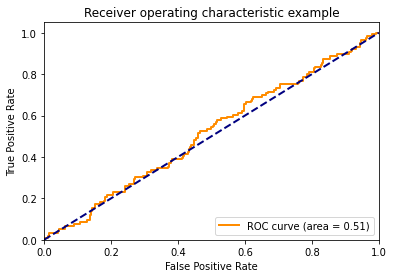

In [20]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()